In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import time
from itertools import product
plt.rcParams['font.size'] = 14

 ### Choose parameters for the training

In [2]:
#Choose data(0=data, 1=data_b, 2=data_c)
CASE=1

#algorithm (vanilla, rms or adam)
algor='vanilla'

#number of epoch
n_epoch=100

#number of conrtastive divergence steps (1=without contrastive steps)
cont_step=1

#Use centering trick or not (only works for algor='vanilla')
centering=False

#number of hidden layers
M=4

#One hot enconding (useful only for data_b and data_c)
one_hot=True

#Amplitude. big(40)->Good for noise reduction, small(1)->Good for recrating data (low error of adversial accuracy indicator)
amplitude=1.

#Validation set
validation=False

#SPINS {-1,1} or BITS {0,1}
SPINS = False

## ====================================================

In [3]:
if CASE==0:
    dname="DATA"
    fname=dname+'/x_RBM_q0.1.dat' 
    G=5
    A=6

if CASE==1: 
    dname="DATA_b"
    fname=dname+'/x_RBM_q0.1.dat' 
    G=5
    A=4
if CASE==2: 
    dname='DATA'
    fname=dname+'/x_RBM_q0.2.dat' 
    block=6
    G=5
    A=6

v = np.loadtxt(fname, delimiter=" ",dtype=int)

if validation == True:
    v0_all = np.copy(v)
    N_tot = len(v)
    L = len(v[1])

    N = int(0.8*N_tot)
    N_valid = N_tot-N

    v = v[:N]
    v0 = np.copy(v)
    v_valid = v[N:]
    
else:
    v0 = np.copy(v)
    N = len(v)
    L = len(v[1])

if SPINS:
    GAP=2
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

# for i in range(min(12,N)):
#     if SPINS: print(v0[i],"\n->",v[i])
#     else: print(v[i])
# print('...')

each of N=10000 data has L=20 digits


## initialize

In [4]:
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-8.35715520e-02  1.95527799e-01 -2.12059967e-01 -2.26875947e-01]
 [ 8.02526558e-01  5.68855549e-01  3.79294819e-02  1.15022385e-01]
 [ 3.13952149e-01  5.08854850e-01  4.11183333e-01 -5.29180052e-01]
 [ 1.12264864e-01  9.34532915e-02  5.52325985e-01  3.61883263e-01]
 [-8.17165010e-01 -1.51804080e-01  6.81376729e-01 -1.79045345e-01]
 [-2.20348522e-01  1.94728315e-01  1.32637580e+00 -4.16914391e-01]
 [-2.35594905e-01  5.06722986e-02  1.23541469e-01  2.13829051e-01]
 [ 3.83866794e-04  5.48608051e-01 -2.91303112e-01 -3.39317011e-01]
 [-9.67643021e-01 -7.59652411e-01 -3.51402736e-01  2.28678358e-01]
 [-5.16815592e-01  4.89192188e-02 -4.34177139e-01  1.35898800e-01]
 [-9.63228695e-01 -8.14630704e-02 -6.29517038e-01 -3.96301277e-01]
 [-5.33592866e-01  1.16901795e-01  1.54311367e-01 -3.07772889e-01]
 [ 1.35246800e-01  5.51029952e-01  2.85270388e-02  1.00704284e-01]
 [-4.84247836e-03  4.10212614e-01  5.41824932e-01 -3.75286959e-01]
 [-6.32420055e-01  9.05682448e-03  3.09600458e-01 -2.696579

## Plotting

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1]


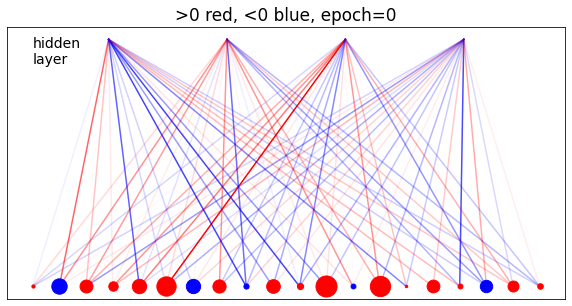

In [5]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph()

In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,center,neg,info=False):
    if neg==0:
        act = np.dot(v_in-center, wei) + bias
        n = np.shape(act)
        prob = 1. / (1. + exp(-DE*act))
        v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
        v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
        if info:
            print('input=', v_in)
            print('act=',act)
            print('prob=',prob)
            print('output=',v_out)
    if neg==1:
        v = np.diag([1]*A)
        v[v==0] = vmin
        act = np.dot(v_in-center, wei) + bias
        energies = np.dot(v,act.reshape(G,A).T)
        P = np.exp(DE * energies)
        Prob = P/np.sum(P, axis=0)
        C = np.cumsum(Prob, axis=0)
        mask = np.argmax(C > np.random.rand(G), axis=0)
        v_out=v[mask, :].reshape(-1)
    
    return v_out

In [7]:
def energies_RBM(v,h,w,v_bias,h_bias):
    if h.shape[0] == M:
        s = 1
    else: 
        s = 2**M
    
    energies = - (v @ ((w @ h.T).reshape(A*G,s) + v_bias.reshape(A*G,1)) + h @ h_bias)
    return (energies)

In [8]:
#partition function
def partition_function(v,h,w,v_bias,h_bias,DE):
    Z = np.sum(exp(-energies_RBM(v,h,w,v_bias,h_bias)*DE))
    return Z

In [9]:
def ll(size, ene_sum, z):
    likelihood = pow(size, -1)* np.sum(np.log(ene_sum)) - np.log(z)
    return likelihood

In [10]:
#measures the advesial accuracy indicator (As->imput=(v0,v2), At->imput=(v2,v0))
def accuracy(v0,v2):
    count=0
    for i in range(N):
        dss=np.concatenate((v0[:i,:],v0[i+1:,:]))-v0[i,:]
        dss[dss==-1]=1
        dss_sum=np.min(np.sum(dss,axis=1))
        
        
        dst=np.concatenate((v2[:i,:],v2[i+1:,:]))-v0[i,:]
        dst[dst==-1]=1
        dst_sum=np.min(np.sum(dst,axis=1))
        
        
        if dss_sum<dst_sum:
            count+=1
        elif dss_sum==dst_sum:
            count+=1/2
        dss,dst=(0,0)
    return(count/N)

## RBM train


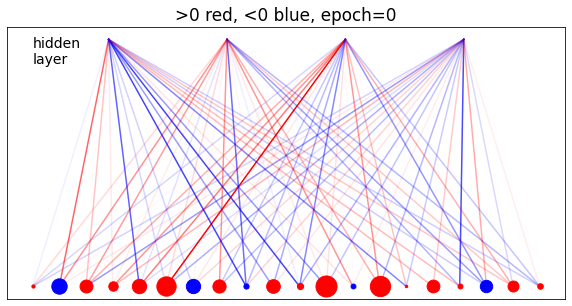

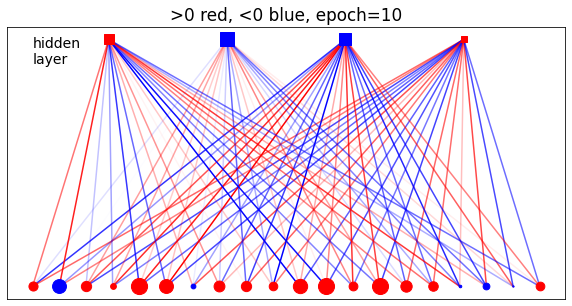

l_rate =  0.9090909090909092     # epoch =  10


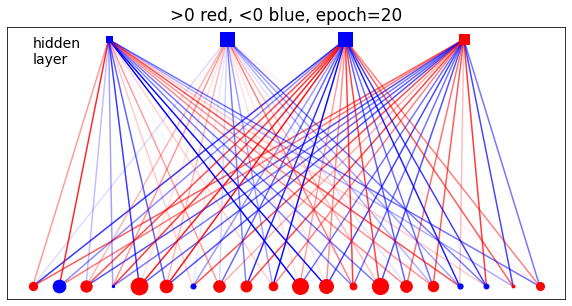

l_rate =  0.8333333333333337     # epoch =  20


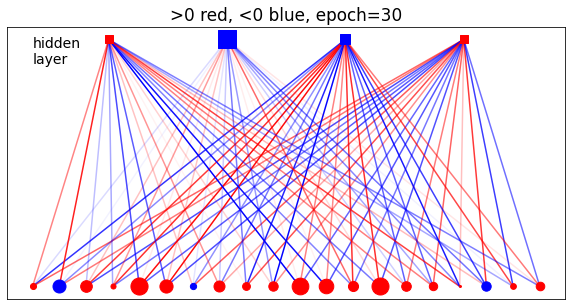

l_rate =  0.7692307692307697     # epoch =  30


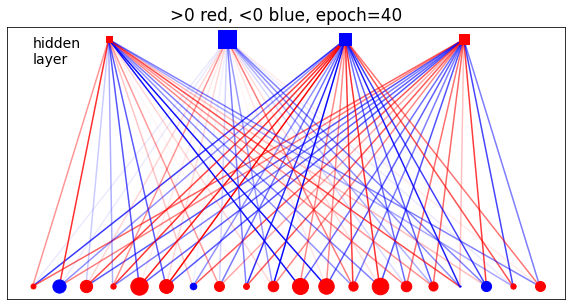

l_rate =  0.7142857142857149     # epoch =  40


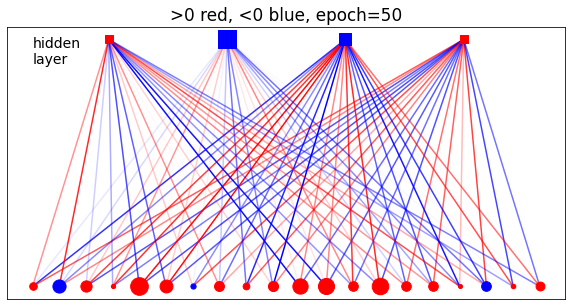

l_rate =  0.6666666666666671     # epoch =  50


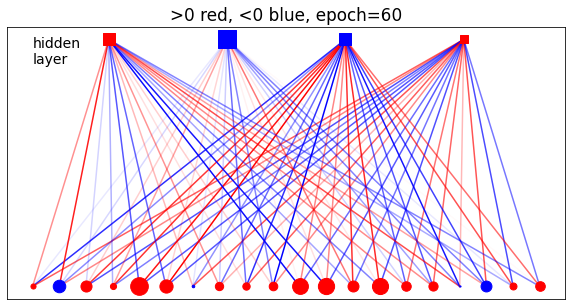

l_rate =  0.6250000000000006     # epoch =  60


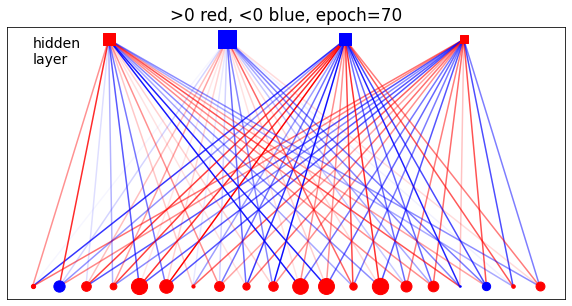

l_rate =  0.5882352941176475     # epoch =  70


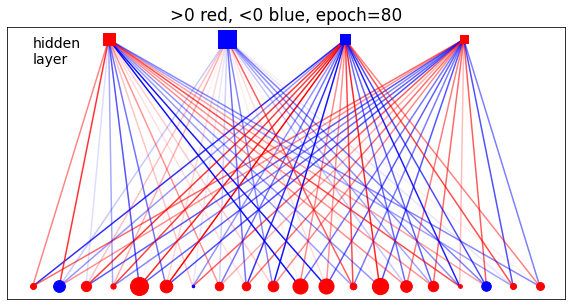

l_rate =  0.555555555555556     # epoch =  80


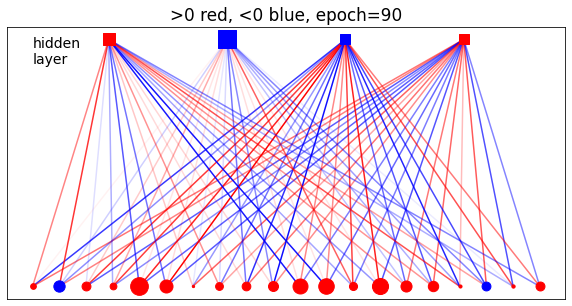

l_rate =  0.5263157894736847     # epoch =  90


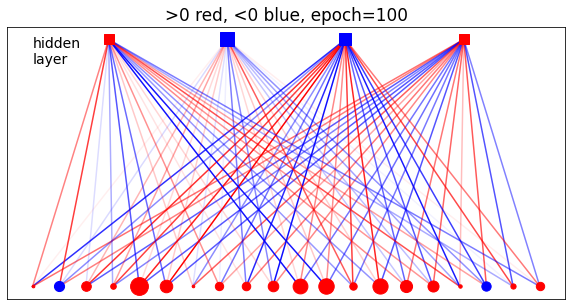

l_rate =  0.5000000000000009     # epoch =  100


In [11]:
neg = 0
if one_hot == True:
    neg = 1
    
c_mu = 0
c_lamb = 0
if centering == True:
    c_mu = 0.01
    c_lamb = 0.01
mu = np.zeros(L)
lamb = np.zeros(M)

#parameters rms
beta = 0.9
eps = 1e-8

#parameters adam
b1 = 0.9
b2 = 0.99
eps = 1e-8


plotgraph(0)

# learning rate
l_rate = 1

# minibatch
mini, m = 500, 0

# Training and Validation parameters

if validation == True:
    train_perc = 0.8
else:
    train_perc = 1
    
N_train = int(train_perc*N)
N_valid = N - N_train

e_sum_D = 0.0
e_sum_RBM = np.zeros(N_train)
e_sum_V = np.zeros(N_valid)

energy_RBM = np.zeros(n_epoch)
energy_D = np.zeros(n_epoch)
energy_V = np.zeros(n_epoch)

part_func = np.zeros(n_epoch)

likelihood_D = np.zeros(n_epoch)
likelihood_RBM = np.zeros(n_epoch)
likelihood_V = np.zeros(n_epoch)

#AAI parameters
accuracy_s = 0
accuracy_t = 0
error = 0

# train model
l_rate = 1
# M=h_layer[h_l]

#for partition function
four = np.eye(A,dtype=int)
v_all = np.array(list(product(four, repeat=G))).reshape(A**G,-1)
h_all = np.array(list(product(range(2),repeat=M)))


#np.random.seed(12345)
for epoch in range(n_epoch):
    # np.random.shuffle(v)
    v_train = v[:N_train]
    v_valid = v[N_train:]
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate/mini
    t=1
    for k in range(N_train):
        if m==0:
            # initialize averages in miniblock
            v_data_l, v_model_l= np.zeros((N_train,L)),np.zeros((N_train,L))
            h_data_l, h_model_l= np.zeros((N_train,M)),np.zeros((N_train,M))

            mw = np.zeros((L,M))
            ma = np.zeros(L)
            mb = np.zeros(M)

            sw = np.zeros((L,M))
            sa = np.zeros(L)
            sb = np.zeros(M)

            mh_w = np.zeros((L,M))
            mh_a = np.zeros(L)
            mh_b = np.zeros(M)

            sh_w = np.zeros((L,M))
            sh_a = np.zeros(L)
            sh_b = np.zeros(M)
        
        h = activate(v_train[k],w,b,GAP,mu,0)
        hf = np.copy(h)     
        for j in range(cont_step):
        # negative CD phase: generating fantasy vf
            vf = activate(hf,w.T,a,GAP,lamb,neg)
        # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,w,b,GAP,mu,0)

        energy_D[epoch] += energies_RBM(v_train[k],h,w,a,b)
        energy_RBM[epoch] += energies_RBM(vf,hf,w,a,b)
        e_sum_RBM[k] = np.sum(np.exp(-energies_RBM(vf, h_all, w, a, b)))

        v_data_l[k] = v_train[k]
        v_model_l[k] = vf
        h_data_l[k] = h
        h_model_l[k] = hf

        m += 1
        # minibatch
        if m==mini:

            v_data_ = v_data_l[(t-1)*mini:t*mini,:]
            v_model_ = v_model_l[(t-1)*mini:t*mini,:]
            h_data_ = h_data_l[(t-1)*mini:t*mini,:]                           
            h_model_ = h_model_l[(t-1)*mini:t*mini,:]       

            mu_batch = np.mean(v_data_,axis=0)
            lamb_batch = np.mean(h_data_,axis=0)
            a = a + c_lamb*np.dot(w,(lamb_batch - lamb))
            b = b + c_mu*np.dot(w.T,(mu_batch - mu))

            mu = (1 - c_mu)*mu + c_mu*mu_batch
            lamb = (1 - c_lamb)*lamb + c_lamb*lamb_batch

            v_data = np.sum(v_data_,axis=0)
            v_model = np.sum(v_model_,axis=0)
            h_data = np.sum(h_data_,axis=0)                              
            h_model = np.sum(h_model_,axis=0)

            vh_data = np.dot((v_data_ - mu).T,(h_data_ - lamb))
            vh_model = np.dot((v_model_ - mu).T,(h_model_ - lamb))

            # gradient of the likelihood: follow it along its positive direction

            if algor == "vanilla":
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)

            if algor == "rms":

                l_rate = 0.01

                sw=beta*sw+(1-beta)*(vh_data - vh_model)**2
                sa=beta*sa+(1-beta)*(v_data - v_model)**2
                sb=beta*sb+(1-beta)*(h_data - h_model)**2

                dw = l_rate_m*(vh_data - vh_model)/(np.sqrt(sw+eps))
                da = l_rate_m*(v_data - v_model)/(np.sqrt(sa+eps))
                db = l_rate_m*(h_data - h_model)/(np.sqrt(sb+eps))

            if algor == "adam":

                l_rate = 0.01

                gw = vh_model - vh_data
                ga = v_model - v_data
                gb = h_model - h_data

                mw = b1*mw + (1-b1)*gw
                ma = b1*ma + (1-b1)*ga
                mb = b1*mb + (1-b1)*gb

                sw = b2*sw + (1-b2)*gw**2
                sa = b2*sa + (1-b2)*ga**2
                sb = b2*sb + (1-b2)*gb**2


                mh_w = mw/(1-(b1)**t)
                mh_a = ma/(1-(b1)**t)
                mh_b = mb/(1-(b1)**t)


                sh_w = sw/(1-(b2)**t)
                sh_a = sa/(1-(b2)**t)
                sh_b = sb/(1-(b2)**t)


                dw = -l_rate_m*mh_w/np.sqrt(sh_w + eps)
                da = -l_rate_m*mh_a/np.sqrt(sh_a + eps)
                db = -l_rate_m*mh_b/np.sqrt(sh_b + eps)

            # basic step of vanilla gradient descent, from eq.(211)

            w = w + dw
            a = a + da
            b = b + db
            m = 0
            t = t + 1

    #Computes the energy for each possible h, then calculates partition function and loglikelihood
    e_sum_D = np.sum(np.exp(-energies_RBM(v_train,h_all,w,a,b)),axis=1)
    if validation == True:
        energy_V = np.sum(energies_RBM(v_valid,h,w,a,b))
        e_sum_V = np.sum(np.exp(-energies_RBM(v_valid,h_all,w,a,b)),axis=1)
    
    part_func[epoch] = partition_function(v_all,h_all,w,a,b,GAP)
    
    likelihood_D[epoch] = ll(N_train,e_sum_D,part_func[epoch])
    likelihood_RBM[epoch] = ll(N_train,e_sum_RBM,part_func[epoch])
    if validation == True:
        likelihood_V[epoch] = ll(N_valid,e_sum_V,part_func[epoch])

    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate/(0.01*l_rate+1)
    if epoch%10 == 9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate,'   ','# epoch = ',epoch+1)

#ampl=40.
ampl=1

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = activate(v0[k],w,b,amplitude*GAP,mu,0)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = activate(h,w.T,a,amplitude*GAP,lamb,neg)
v2=np.copy(v1)
v2[v2==-1]=0

accuracy_s = accuracy(v0,v2)
accuracy_t = accuracy(v2,v0)
error = (accuracy_s-0.5)**2 + (accuracy_t-0.5)**2


energy_RBM /= N
energy_D /= N
if validation == True:
    energy_V /= N

In [12]:
error

1.5625000000000445e-06

### Accuracy

In [13]:
print('Adversarial Accuracy Indicator on trainig set: ', error)
#print('Adversarial Accuracy Indicator on validation set: ', error)

Adversarial Accuracy Indicator on trainig set:  1.5625000000000445e-06


### Log-Likelihood

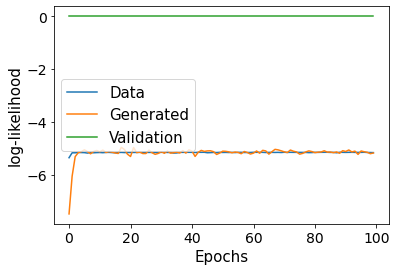

In [14]:
tsteps = np.arange(n_epoch)

plt.plot(tsteps,likelihood_D,label='Data')
plt.plot(tsteps,likelihood_RBM,label='Generated')
plt.plot(tsteps,likelihood_V,label='Validation')
plt.xlabel('Epochs',fontsize='15')
plt.ylabel('log-likelihood',fontsize='15')
plt.legend(fontsize='15')
plt.show()

### Energy

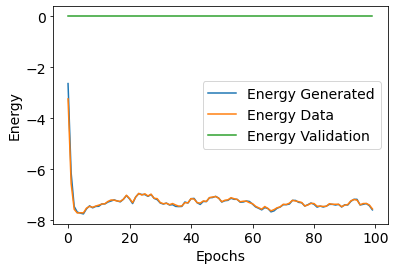

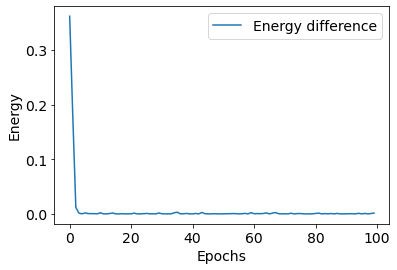

In [15]:
# plt.title('M='+str(h_layer[0]) + ' ' + 'CD-'+str(conv_step_array[0]))
plt.plot(tsteps,energy_RBM,label="Energy Generated")
plt.plot(tsteps,energy_D,label="Energy Data")
plt.plot(tsteps,energy_V,label="Energy Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.show()

# plt.title('M='+str(h_layer[0]) + ' ' + 'CD-'+str(conv_step_array[0]))
delta_energy = (energy_RBM - energy_D)**2
plt.plot(tsteps,delta_energy,label='Energy difference')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.show()

###  Control functions

In [16]:
#measures the number of rows that do not follow a pattern like p-n-p-n-p or n-p-n-p-n. (Being p=polar=[0,1,0,0] or [1,0,0,0]
# and n=non-polar= [0,0,0,1] or [0,0,1,0])

##ONLY VAID FOR data_b
def control(v):    
    count=0
    v_=np.zeros(G)
    polar=[1,-1,1,-1,1]
    non_polar=[-1,1,-1,1,-1]
    for j in range(N):
        for i in range(G):
            v_[i]=v[j,i*4]+v[j,i*4+1]-v[j,i*4+2]-v[j,i*4+3]
 
        if np.all(v_==polar):
            pass
        elif np.all(v_==non_polar):
            pass
        else:
            count+=1
    
    return(count/N*100)

### Test: noise reduction

In [17]:
from IPython.display import display_html 
import pandas as pd

ampl=amplitude

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = activate(v0[k],w,b,ampl*GAP,mu,0)
    # negative CD phase: generating fantasy vf with low T == large GAP

    v1[k]= activate(h,w.T,a,ampl*GAP,lamb,neg)

v2=np.copy(v1)
v2[v2==-1]=0
# difference between fantasy and data
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(mini)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  


def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df_l0 = pd.DataFrame((v0[N-1])).T
df_l1 = pd.DataFrame((v1[N-1]-vmin/(1-vmin)).astype(int)).T

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")

df_l0s = df_l0.style.set_table_attributes("style='display:inline'")
df_l1s = df_l1.style.set_table_attributes("style='display:inline'")

df0s.applymap(is_one)
df1s.applymap(is_one)

df_l0s.applymap(is_one)
df_l1s.applymap(is_one)

sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Denoised').set_table_styles(sty)

df_l0s.set_caption('Original').set_table_styles(sty)
df_l1s.set_caption('Denoised').set_table_styles(sty)

display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)
display_html(df_l0s._repr_html_()+df_l1s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0
,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0


### Weights color plot

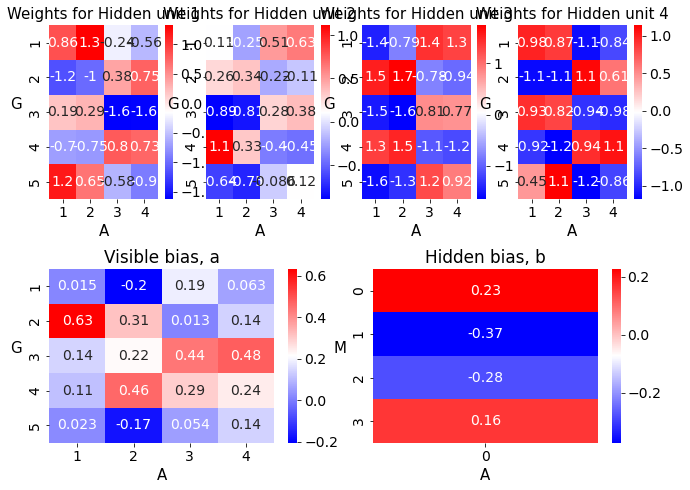

In [18]:
dic=['Hidden unit 1', 'Hidden unit 2', 'Hidden unit 3', 'Hidden unit 4', 'Hidden unit 5', 'Hidden unit 6']

plt.subplots_adjust(left=0.1,
                    bottom=0.05,
                    right=1.5,
                    top=1.5,
                    wspace=0.15,
                    hspace=0.4)

for i in range(w[0].size):
    plt.subplot(2, w[0].size, i+1)

    vals = w[:,i].reshape(G,A)
    sns.heatmap(vals, annot=True, cmap = 'bwr',xticklabels=np.arange(1,A+1),yticklabels=np.arange(1,G+1))
    plt.title('Weights for ' + str(dic[i]), fontsize=15)
    plt.ylabel('G   ', rotation=0, fontsize=15)
    plt.xlabel('A', fontsize=15)
    

vals_a = a.reshape(G,A)
plt.subplot(2,2,3)
sns.heatmap(vals_a, annot=True, cmap = 'bwr',xticklabels=np.arange(1,A+1),yticklabels=np.arange(1,G+1))
plt.title('Visible bias, a')
plt.ylabel('G   ', rotation=0, fontsize=15)
plt.xlabel('A', fontsize=15)


vals_b = b.reshape(M,1)
plt.subplot(2,2,4)
sns.heatmap(vals_b, annot=True, cmap = 'bwr')
plt.title('Hidden bias, b')
plt.ylabel('M   ', rotation=0, fontsize=15)
plt.xlabel('A', fontsize=15)

plt.show()

### Show results for control

In [19]:
n_mistaken_v0=control(v0)
n_mistaken_v2=control(v2)

print('Number of mistaken rows in original data:',n_mistaken_v0,'\n','Number of mistaken rows in created data:',n_mistaken_v2)

Number of mistaken rows in original data: 22.6 
 Number of mistaken rows in created data: 21.14
